# Mushroom Binary Classification with Feedforward Neural Network
### STAT 479 Midterm Project
**Bonnie Tran**

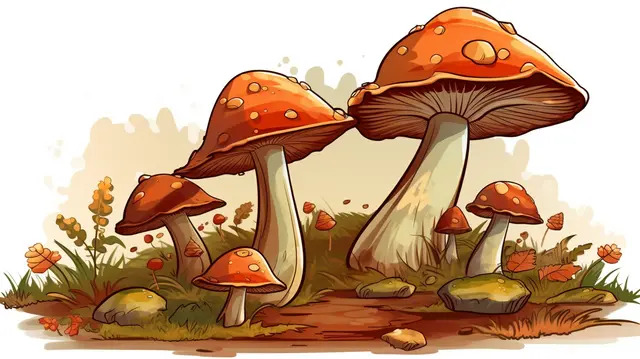

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Import libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from feature_engine.encoding import CountFrequencyEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
import tensorflow as tf
import keras
import random

# Load mushroom dataset

**Kaggle**: https://www.kaggle.com/datasets/bwandowando/mushroom-overload

In [3]:
mushroom_dataset = pd.read_csv("C:/Users/bonni/Documents/479/Midterm/mushroom_dataset.csv")
mushroom_dataset.head(3)

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,17.18,f,g,e,f,e,NaN,w,18.58,...,s,y,w,u,w,t,g,NaN,d,a
1,p,15.30,x,h,e,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.94,f,h,o,f,e,NaN,w,16.84,...,s,y,w,u,w,t,p,NaN,d,a


# Quick look at data shape and type

The `mushroom_dataset` has 21 columns: 

In [4]:
mushroom_dataset.shape

(6723116, 21)

- Binary target:
  - **`class`**: e=edible, p=poisonous

- 20 features: 

**3 NUMERICAL**:
- **`cap-diameter`**: float number in cm
- **`stem-height`**: float number in cm
- **`stem-width`**: float number in mm

According to the kaggle website, here are the unique values per categorical column:

**17 CATEGORICAL**: _(Categorical features can be categorized into 4 main groups)_

   - _**Group 1**: Features to encode._
     - **`cap-shape`**: bell=b, conical=c, convex=x, flat=f, sunken=s, spherical=p, others=o
     - **`gill-attachment`**: adnate=a, adnexed=x, decurrent=d, free=e, sinuate=s, pores=p, none=f, unknown=?
     - **`gill-spacing`**: close=c, distant=d, none=f
     - **`stem-root`**: bulbous=b, swollen=s, club=c, cup=u, equal=e, rhizomorphs=z, rooted=r
     - **`ring-type`**: cobwebby=c, evanescent=e, flaring=r, grooved=g, large=l, pendant=p, sheathing=s, zone=z, scaly=y, movable=m, none=f, unknown=?
     - **`habitat`**: grasses=g, leaves=l, meadows=m, paths=p, heaths=h, urban=u, waste=w, woods=d
     - **`season`**: spring=s, summer=u, autumn=a, winter=w

   - _**Group 2**: Features related to **`cap-surface`**._ 
      - **`cap-surface`**: fibrous=i, grooves=g, scaly=y, smooth=s, dry=d, shiny=h, leathery=l, silky=k, sticky=t, wrinkled=w, fleshy=e
      - **`stem-surface`**: see cap-surface + none=f

   - _**Group 3**: Features related to **`cap-color`**._
      - **`cap-color`**: brown=n, buff=b, gray=g, green=r, pink=p, purple=u, red=e, white=w, yellow=y, blue=l, orange=o, black=k
      - **`gill-color`**: see cap-color + none=f
      - **`stem-color`**: see cap-color + none=f
      - **`veil-color`**: see cap-color + none=f
      - **`spore-print-color`**: see cap color

   - _**Group 4**: Binary features._
     - **`does-bruise-bleed`**: bruises-or-bleeding=t,no=f
     - **`veil-type`**: partial=p, universal=u
     - **`has-ring`**: ring=t, none=f
    
The various features that reference either `cap-surface` or `cap-color` should be removed since they are redundant and keeping them will cause multicollinearity to exists in the data. Since these are all categorical features, eliminating them will reduce the chances of encoding insignificant features and adding noise to the data. 

Since there are 6,723,116 rows in the data, removing redundant features will also significantly decrease the computational cost and increase accuracy.

In [5]:
mushroom_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6723116 entries, 0 to 6723115
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 object 
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), object(18)
memory usage: 1.1+ GB


# Drop redundant features related to `cap-surface` and `cap-color`.

In [6]:
drop_cap_features = ['stem-surface', 'gill-color', 'stem-color', 
                     'veil-color', 'spore-print-color']
mushroom_dataset = mushroom_dataset.drop(drop_cap_features, axis=1)

# Analyze null values

In [7]:
null_rows = (mushroom_dataset.isnull().sum()/mushroom_dataset.shape[0])*100
null_rows

class                    0.000000
cap-diameter             0.000000
cap-shape                0.000000
cap-surface             23.491146
cap-color                0.000000
does-bruise-or-bleed     0.000000
gill-attachment         15.866467
gill-spacing            41.657901
stem-height              0.000000
stem-width               0.000000
stem-root               85.726604
veil-type               94.708213
has-ring                 0.000000
ring-type                4.116082
habitat                  0.000000
season                   0.000000
dtype: float64

### Columns with over 30% null values

Three categorical columns `gill-spacing`, `stem-root`, and `veil-type` all have over 30% null values, and consequently, should be dropped. There are no numerical columns with a large amount of null values.

In [8]:
nulls_to_drop = mushroom_dataset.loc[:, null_rows > 30]
nulls_to_drop.head(3)

,gill-spacing,stem-root,veil-type
0,NaN,s,u
1,NaN,s,u
2,NaN,s,u


### 13 columns, including target, remain after dropping columns with large percentage of null

In [9]:
mushroom_dataset = mushroom_dataset.drop([col for col in nulls_to_drop], axis=1)
mushroom_dataset.shape

(6723116, 13)

### Drop duplicates before imputing

6,715,502 rows remain after dropping 7,614 duplicate rows.

In [10]:
original_rows = mushroom_dataset.shape[0]
mushroom_dataset = mushroom_dataset.drop_duplicates()
new_rows = mushroom_dataset.shape[0]

print(f'Rows dropped = {original_rows - new_rows}')
print(f'New shape: {mushroom_dataset.shape}')

Rows dropped = 7614
New shape: (6715502, 13)


### Columns to impute with null under 30%

Another 3 categorical columns `cap-surface`, `gill-attachment`, and `ring-type` have null values. Since these are under 30%, the missing values will be imputed to avoid excessive loss of data. These have 23.49%, 15.83%, and 4.12% null rows respectively.

In [11]:
nulls_to_impute = mushroom_dataset.loc[:, null_rows > 0]
nulls_to_impute.head(3)

,cap-surface,gill-attachment,ring-type
0,g,e,g
1,h,e,g
2,h,e,p


In [12]:
null_percentage = []

for col in nulls_to_impute:
    percentage_to_impute = (
        mushroom_dataset[col].isnull().sum()/len(mushroom_dataset)
    )*100
    null_percentage.append(round(percentage_to_impute, 2))

impute_percentage_df = pd.DataFrame(null_percentage, 
                                    index = nulls_to_impute.columns, 
                                    columns = ['null percentage'])
impute_percentage_df.index.name = 'column'
impute_percentage_df

,null percentage
column,
cap-surface,23.49
gill-attachment,15.83
ring-type,4.12


### Use mode method to impute and check for null after

No null values left as expected.

In [13]:
for col in nulls_to_impute:
    mushroom_dataset[col] = mushroom_dataset[col].fillna(
        mushroom_dataset[col].mode()[0]
    )

recount_null_rows = mushroom_dataset.isnull().sum()
print(f'Nulls after impute:\n{recount_null_rows}')

Nulls after impute:
class                   0
cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
stem-height             0
stem-width              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64


# Check which remaining features are numerical or categorical

In [14]:
numerical_features = list(mushroom_dataset.select_dtypes(
    exclude = ['object']).columns)
categorical_features = list(mushroom_dataset.drop(
    ['class'], axis=1
).select_dtypes('object').columns)

print(f'numerical_features:{len(numerical_features)}\n{numerical_features}')
print(f'\ncategorical_features:{len(categorical_features)}\n{categorical_features}')

numerical_features:3
['cap-diameter', 'stem-height', 'stem-width']

categorical_features:9
['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'has-ring', 'ring-type', 'habitat', 'season']


# Map binary features

Map `has-ring` and `does-bruise-or-bleed` to 1 if true and 0 if false.

In [15]:
binary_features = [col for col in categorical_features 
                   if mushroom_dataset[col].nunique() == 2]
print(f'binary features: {binary_features}')

binary features: ['does-bruise-or-bleed', 'has-ring']


In [16]:
bruise_bleed = {'t':1, 'f':0}
ring = {'t':1, 'f':0}

mushroom_dataset['does-bruise-or-bleed'] = mushroom_dataset[
                                                            'does-bruise-or-bleed'
                                                            ].map(ring)
mushroom_dataset['has-ring'] = mushroom_dataset['has-ring'].map(ring)

In [17]:
mushroom_dataset.head(3)

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,stem-height,stem-width,has-ring,ring-type,habitat,season
0,p,17.18,f,g,e,0,e,18.58,18.52,1,g,d,a
1,p,15.30,x,h,e,0,e,16.95,17.08,1,g,d,u
2,p,14.94,f,h,o,0,e,16.84,16.74,1,p,d,a


# Sample data based on target `value_counts()`

Since there are 6,715,502 observations, taking a sample size to plot, train, evaluate, etc. will save time and be less computationally expensive.To provide a sense of controlled variability and reproducibility, the sample size will be derived from grouping the data based on the target `class` and employing the `random_state` parameter. As a result, the likelihood of the sample data representing the whole data is much higher than randomly sampling based on a feature.

There are 3,673,556 poison observations and 3,041,946 edible observations, which equal to 55% and 45% respectively. By grouping before sampling, this proportion between the poison and edible class type remain consistent no matter the sample fraction.

In [18]:
# proportions of poison and edible class types from the entire dataset

class_value_counts = mushroom_dataset['class'].value_counts()
print(class_value_counts)

poison_ratio = class_value_counts[0]/len(mushroom_dataset)
edible_ratio = class_value_counts[1]/len(mushroom_dataset)

print(f'\npoison ratio: {round(poison_ratio, 2)}')
print(f'edible ratio: {round(edible_ratio, 2)}')

class
p    3673556
e    3041946
Name: count, dtype: int64

poison ratio: 0.55
edible ratio: 0.45


### Create a function to calculate the proportions of the sample data and return a sample dataframe

Parameters:
- **`random_state`**: Random state of sample size for reproducibility.
- **`frac`**: Fraction of the data to sample. (Default `frac=0.05`)
- **`verbose`**: If True, function will print out information about number of sample rows, etc. (Default `verbose=False`)

In [19]:
def get_mushroom_sample(random_state, frac=0.05, verbose=False):
    
    mushroom_sample_dataset = mushroom_dataset.groupby('class').sample(
                                                            frac=frac, 
                                                            random_state=random_state
                                                                       )

    if verbose:
        class_value_counts = mushroom_sample_dataset['class'].value_counts()
        print(class_value_counts)
    
        poison_ratio = class_value_counts[0]/len(mushroom_sample_dataset)
        edible_ratio = class_value_counts[1]/len(mushroom_sample_dataset)

        print(f'\npoison sample ratio: {round(poison_ratio, 2)}')
        print(f'edible sample ratio: {round(edible_ratio, 2)}')
        print(f'sample shape: {mushroom_sample_dataset.shape}\n')
    
    return mushroom_sample_dataset

### Check to see if function works.
As expected, the default parameter `verbose=False` will not print out additional information on the number of sample rows or data shape. However, if specified with `verbose=True`, the function will. This is convenient since sometimes it's nice to check for details pertaining to the sample data, but other times. only a dataframe is necessary (i.e., plotting, modeling, etc.)

In [20]:
mushroom_sample_dataset = get_mushroom_sample(0)
mushroom_sample_dataset.head(3)

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,stem-height,stem-width,has-ring,ring-type,habitat,season
247464,e,3.18,x,t,b,0,a,7.19,4.89,0,f,d,a
5062201,e,5.93,b,h,k,0,s,4.64,10.27,0,f,d,a
2051447,e,13.61,x,y,n,1,e,10.01,18.19,1,f,g,u


In [21]:
mushroom_sample_dataset_verbose = get_mushroom_sample(0, verbose=True)
mushroom_sample_dataset_verbose.head(3)

class
p    183678
e    152097
Name: count, dtype: int64

poison sample ratio: 0.55
edible sample ratio: 0.45
sample shape: (335775, 13)



,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,stem-height,stem-width,has-ring,ring-type,habitat,season
247464,e,3.18,x,t,b,0,a,7.19,4.89,0,f,d,a
5062201,e,5.93,b,h,k,0,s,4.64,10.27,0,f,d,a
2051447,e,13.61,x,y,n,1,e,10.01,18.19,1,f,g,u


# Create function to preprocess columns with different methods

### Map binary target `class` 

This mapping has been intentionally ignored up to now, so `value_counts()` results can explicitly display how many rows are from the poison and edible class each, and distribution plots can show the respective hues clearly.

Map `class` to 1 if poison and 0 if edible.

### Split data into train, validation, and test sets

Employ `train_test_split` to split data. Since even the sample data is large, the `test_size=0.3` when splitting from the train set, and `test_size=0.5` when splitting validation and test sets.

### Frequency encoding nominal features

These are all nominal categorical features with either high-cardinality or unbalanced value counts, so ordinal, one-hot, or label encoding are not the most optimal even though they are popular methods. Target encoding can cause leakage since it is based on the mean of the feature with respect to the target variable. Since many of these have unbalanced value counts, target encoding could contribute to an inaccurate representation of data.

Alternatively, frequency encoding is based on the frequency of each unique value within the feature. It doesn't have to be with respect to the target `class` to work nor does it add additional dimensions to the dataframe, so it's a safe encoding method. If two unique values have the same frequency within the data, they will both be mapped to the same frequency. Usually, this could be disadvantageous since it potentially omits important information from distinct categories. However, the advantages associated with frequency encoding outweight the disadvantages for this particular dataset.

A downside is if the model encounters a feature category that doesn't exists in the training data due to extremely low frequency, it won't be encoded. However, the whole dataset is 6 million plus rows, so taking a bigger sample size will most likely solve that issue if it comes up. 

### Standard scaling numerical features

Although the parameter `ignore_format=True` within the `CountFrequencyEncoder()` object allows numerical variables to also be frequency encoded, it would mess up the current data. Since the frequency encoding returns probabilities between 0 and 1 for the `value_counts()` of each nominal feature, a suitable counterpart for also returning probabilities between 0 and 1 for the numerical variables is standard scaling.

In [22]:
# Only encode multi-class nominal features
encoding_features = [col for col in categorical_features 
                     if col not in binary_features]

print(f'encoding features: {encoding_features}')

encoding features: ['cap-shape', 'cap-surface', 'cap-color', 'gill-attachment', 'ring-type', 'habitat', 'season']


In [23]:
def preprocessor(random_state):
    
    # get mushroom sample dataframe from get_mushroom_sample function
    mushroom_sample_dataset = get_mushroom_sample(random_state)
    
    # map binary target variable
    class_type = {'p':1, 'e':0}
    mushroom_sample_dataset['class'] = mushroom_sample_dataset[
                                                        'class'
                                                        ].map(class_type)
    
    # split data into train, validation, and test sets for encoding and scaling
    X = mushroom_sample_dataset.drop(['class'], axis=1)
    y = mushroom_sample_dataset['class']
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, 
                                                        y, 
                                                        test_size=0.3, 
                                                        random_state=random_state)
    X_validation, X_test, y_validation, y_test = train_test_split(X_temp, 
                                                                y_temp, 
                                                                test_size=0.5, 
                                                                random_state=random_state)

    # frequency encode nominal variables
    encoder = CountFrequencyEncoder(encoding_method='frequency', 
                                    variables=encoding_features)
    X_train = encoder.fit_transform(X_train)
    X_validation = encoder.transform(X_validation)
    X_test = encoder.transform(X_test)
        
    # standard scale numerical variables
    scaler = StandardScaler()
    X_train[numerical_features] = scaler.fit_transform(
                                                       X_train[numerical_features]
                                                       )
    X_validation[numerical_features] = scaler.transform(
                                                        X_validation[numerical_features]
                                                       )
    X_test[numerical_features] = scaler.transform(
                                                  X_test[numerical_features]
                                                 )


    return X_train, X_validation, X_test, y_train, y_validation, y_test

### Check to see if function works.

Change `random_state` parameter in the cell below to test out reproducibility for other sample data.

In [24]:
X_train, X_validation, X_test, y_train, y_validation, y_test = preprocessor(0)

In [25]:
print(X_train.shape)
X_train.head(3)

(235042, 12)


,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,stem-height,stem-width,has-ring,ring-type,habitat,season
4632995,-0.047450,0.445733,0.366990,0.403941,0,0.171463,-0.541615,-0.300765,0,0.829771,0.052676,0.086419
1370572,0.183035,0.445733,0.106011,0.124778,1,0.371572,0.505922,0.150400,1,0.023196,0.132687,0.371589
6617178,0.341729,0.445733,0.036547,0.403941,0,0.122970,3.299353,-0.425086,0,0.829771,0.717872,0.371589


In [26]:
print(X_validation.shape)
X_validation.head(3)

(50366, 12)


,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,stem-height,stem-width,has-ring,ring-type,habitat,season
6595445,0.126358,0.445733,0.36699,0.403941,1,0.099191,1.504877,1.251241,0,0.829771,0.717872,0.498949
6215039,0.160364,0.118651,0.36699,0.058585,1,0.171463,-0.565906,-0.078190,1,0.829771,0.717872,0.498949
1963666,-0.336500,0.445733,0.36699,0.058585,0,0.371572,-0.729868,-0.664704,1,0.035440,0.717872,0.086419


In [27]:
print(X_test.shape)
X_test.head(3)

(50367, 12)


,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,stem-height,stem-width,has-ring,ring-type,habitat,season
5945826,0.802698,0.445733,0.366990,0.403941,1,0.371572,0.985663,0.719869,1,0.020435,0.717872,0.371589
5264219,0.290720,0.445733,0.037040,0.403941,0,0.371572,1.216425,0.151402,0,0.829771,0.717872,0.498949
3678680,-0.767242,0.445733,0.078748,0.403941,0,0.371572,0.010999,-0.961470,0,0.829771,0.717872,0.498949


In [28]:
print(y_train.shape)
y_train.head(3)

(235042,)


4632995    1
1370572    1
6617178    1
Name: class, dtype: int64

In [29]:
print(y_validation.shape)
y_validation.head(3)

(50366,)


6595445    0
6215039    1
1963666    1
Name: class, dtype: int64

In [30]:
print(y_test.shape)
y_test.head(3)

(50367,)


5945826    0
5264219    1
3678680    1
Name: class, dtype: int64

### Check to see if frequency encoding returns non-encoded values 

Earlier, a disadvantage associated with frequency encoding is that sometimes a feature category with extremely low frequency might not show up in the data and remain non-encoded as a result. This could cause issues in the model training later.

After double-checking, there are no null values in any of the `X_train`, `X_validation`, `X_test`, `y_train`, `y_validation`, or `y_test`. This is great and kind of expected too since there was such a large dataset to begin with that the likelihood of a low-frequency category left unencoded was small.

In [31]:
data_sets = [X_train, X_validation, X_test, y_train, y_validation, y_test]

for data_set in data_sets:
    print(data_set.isnull().sum(), '\n')

cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
stem-height             0
stem-width              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64 

cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
stem-height             0
stem-width              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64 

cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
stem-height             0
stem-width              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64 

0 

0 

0 



# Feature selection

### Correlation heatmap

At this point, there are 12 input features remaining: `cap-diameter`, `cap-shape`, `cap-surface`, `cap-color`, `does-bruise-or-bleed`, `gill-attachment`, `stem-height`, `stem-width`, `has-ring`, `ring-type`, `habitat`, and `season`. It's a lot less to worry about than the original 20, but there's a chance some of these are still highly correlated, which will cause multicollinarity to exist and weaken the model. 

To visualize features with high correlation to each other, a heatmap is plotted.

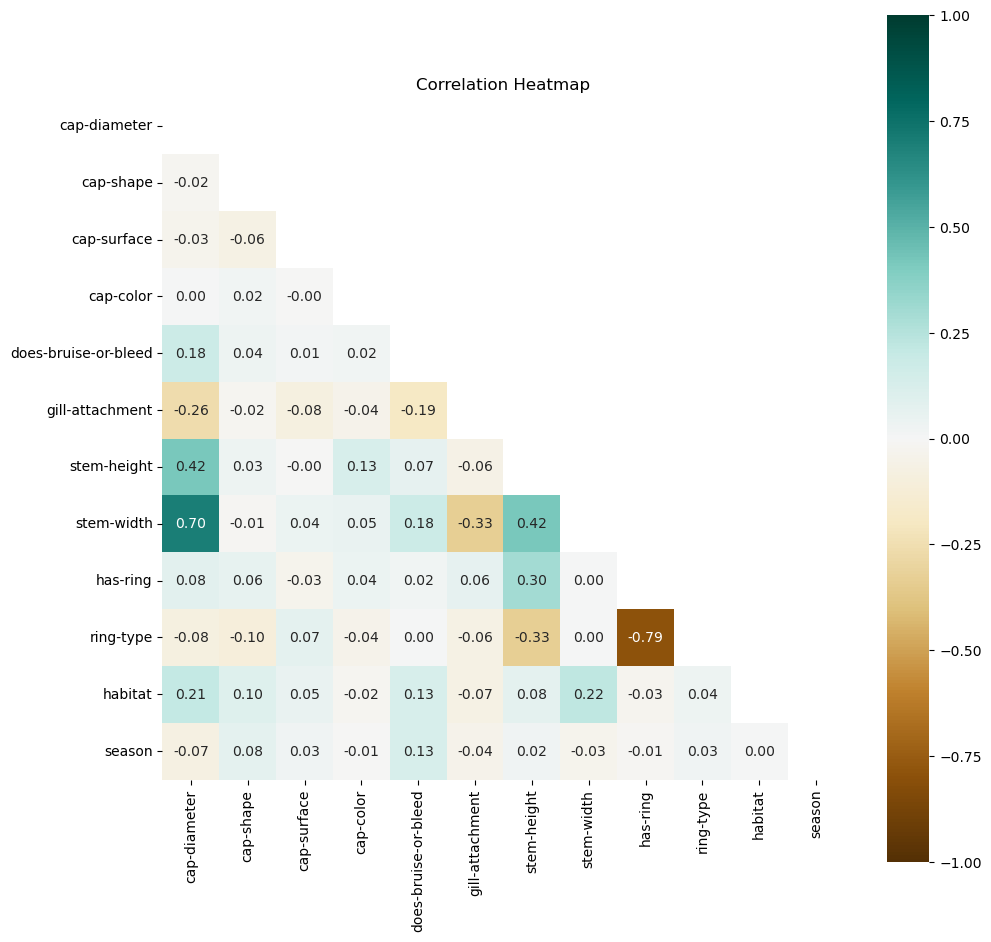

In [32]:
corr = X_train.corr()

plt.figure(figsize=(11, 11))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap = "BrBG", 
            cbar=True, square=True, vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

### Embedded feature selection: Lasso (L1 Regularization)

There's clearly some highly correlated features such as `has-ring` and `ring-type`, and `cap-diameter` and `stem-width` to mention a few. The heatmap shows that `cap-diameter` is highly correlated with quite a few other features too.

Although using filter methods such as correlation to select features isn't bad, the method is independent in the sense that it doesn't consider relations to the target variable much. Applying an embedded method such as Lasso Regression accounts for this correlation to the target `class` that the heatmap misses.

The idea is that L1 regularization drives coefficients to zero if the corresponding features are insignificant to the target (i.e., Some features out of the 12 can be removed if they don't affect whether the mushroom is poisonous or edible). Here, `alpha=0.005`. If alpha is too large, Lasso doesn't work very well and all the coefficients end up equaling zero. Inputs are required to train a FNN, so this value is crucial. 

If features are removed, as expected from the high correlation displayed in the heatmap, then there will be less inputs for the FNN later.

In [33]:
lasso = Lasso(alpha=0.005, random_state=479)

lasso.fit(X_train, y_train)

lasso_coeff = np.abs(lasso.coef_)
print(lasso.coef_)

[-0.04351453 -0.04593777  0.         -0.14949104  0.          0.00702079
 -0.0097315  -0.04871569  0.05624306 -0.          0.          0.13565734]


### Drop features with coefficients equal to zero

The array shows four features are redundant and should be removed. The remaining top 8 features include `gill-attachment`, `stem-height`, `cap-diameter`, `cap-shape`, `stem-width`, `has-ring`, `season`, and `cap-color`.

This means the four features removed are `cap-surface`, `does-bruise-or-bleed`, `ring-type`, and `habitat`. This isn't very surprising since there's already features related to both cap and ring that are highly correlated, and all mushrooms bruise (as other foods do).

In [34]:
best_features = np.argsort(lasso_coeff)[-8:] 
selected_features = X_train.columns[best_features]
print(f"Best Lasso Features: {selected_features.tolist()}\n")

Best Lasso Features: ['gill-attachment', 'stem-height', 'cap-diameter', 'cap-shape', 'stem-width', 'has-ring', 'season', 'cap-color']



In [35]:
X_train = X_train.drop(['cap-surface','does-bruise-or-bleed',
                        'ring-type','habitat'], axis=1)
X_validation = X_validation.drop(['cap-surface','does-bruise-or-bleed',
                                  'ring-type','habitat'], axis=1)
X_test = X_test.drop(['cap-surface','does-bruise-or-bleed',
                      'ring-type','habitat'], axis=1)

### Check updated dataframes

In [36]:
print(X_train.shape)
X_train.head(3)

(235042, 8)


,cap-diameter,cap-shape,cap-color,gill-attachment,stem-height,stem-width,has-ring,season
4632995,-0.047450,0.445733,0.403941,0.171463,-0.541615,-0.300765,0,0.086419
1370572,0.183035,0.445733,0.124778,0.371572,0.505922,0.150400,1,0.371589
6617178,0.341729,0.445733,0.403941,0.122970,3.299353,-0.425086,0,0.371589


In [37]:
print(X_validation.shape)
X_validation.head(3)

(50366, 8)


,cap-diameter,cap-shape,cap-color,gill-attachment,stem-height,stem-width,has-ring,season
6595445,0.126358,0.445733,0.403941,0.099191,1.504877,1.251241,0,0.498949
6215039,0.160364,0.118651,0.058585,0.171463,-0.565906,-0.078190,1,0.498949
1963666,-0.336500,0.445733,0.058585,0.371572,-0.729868,-0.664704,1,0.086419


In [38]:
print(X_test.shape)
X_test.head(3)

(50367, 8)


,cap-diameter,cap-shape,cap-color,gill-attachment,stem-height,stem-width,has-ring,season
5945826,0.802698,0.445733,0.403941,0.371572,0.985663,0.719869,1,0.371589
5264219,0.290720,0.445733,0.403941,0.371572,1.216425,0.151402,0,0.498949
3678680,-0.767242,0.445733,0.403941,0.371572,0.010999,-0.961470,0,0.498949


# NOTE:

At this stage, all of the following preprocessing steps are complete:
- Dropping 5 columns redundant columns (i.e. description = see XYZ feature)
- Dealing with null values
  - Dropping 3 columns with null greater than 30%
  - Imputing 3 columns with the mode for null less than 30%
- Mapping binary features
- Sampling data to reduce computational expense
- Splitting data into train, validation, and test sets
- Encoding nominal features and scaling numerical features
  - Checking if any low-frequency categories cause non-encoded values (No they don't!)
- Selecting features
  - Heatmap
  - Lasso (L1 regularization) --> Deleted 4 more features!

Since the frequency encoding method was used on the nominal variables, no dimensions (features) were added to the sample dataframe. 

# Before building the FNN, visualize distributions for the remaining features

All the train, validation, and test sets have been split at this stage. For simplicity's sake, let's only visualize data for the training set pertaining to input features in the FNN. The `X` and `y` sets will need to be concatenated first since most plot types require a target label.

The displot, a combination of the histogram and the kde plot, shows both the bars and curves representative of each feature's distribution with respect to the target `class`. Here, `class` has already been mapped from poison to 1 (orange) and edible to 0 (blue). Noticeably, the distribution curve with respect to poison for each input feature is always a little higher than for edible.

None of the distributions appear to be normal despite frequency encoding and standard scaling squashing all category values between 0 and 1. The distributions for the three numerical features `cap-diameter`, `stem-height`, and `stem-width` are all right-skewed, while the distributions for the categorical features are all very spread out. This isn't unexpected for the categorical distributions since there is at least one class per categorical feature that has a higher frequency than others.

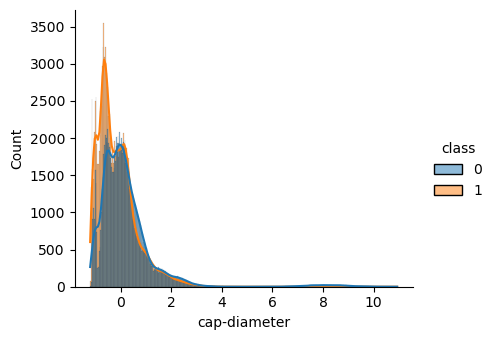

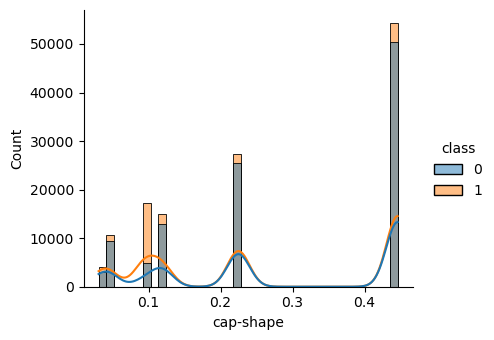

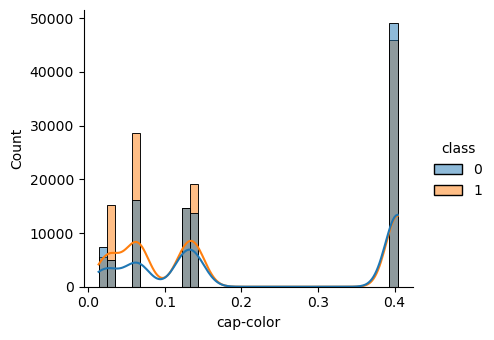

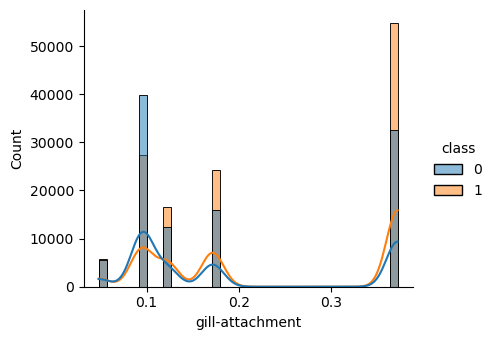

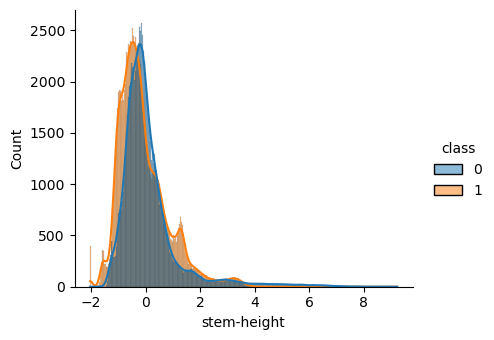

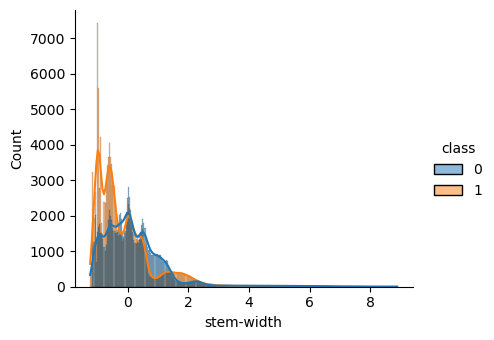

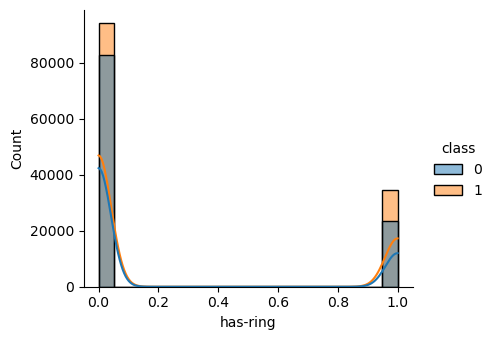

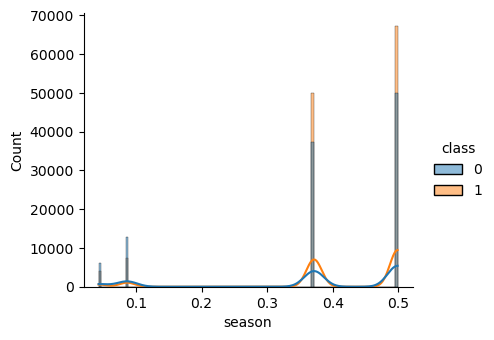

In [39]:
train_set = pd.concat([X_train, y_train], axis=1)

for col in X_train.columns:
    sns.displot(data=train_set, x=col, hue='class', kde=True, height=3.5, aspect=1.25)
    plt.show()

# It's time to train the FNN! 

There will be 8 input features: `gill-attachment`, `stem-height`, `cap-diameter`, `cap-shape`, `stem-width`, `has-ring`, `season`, and `cap-color`. Since the target `class` is binary, the `sigmoid` activation function is used.

In [40]:
# R for rows, C for columns
R, C = X_train.shape
print(R, C)

235042 8


# Create a function to set `learning_rate`, `epochs`, and `batch_size` 

### Tune hyperparameters with common values
- `learning_rate=[0.0001, 0.001, 0.01]`
- `epochs` (depends on results of when overfitting starts)
  - start with `epochs=100`
- `batch_size=[32, 64, 128, 256]`

In [41]:
def train_FNN(learning_rate, epochs, batch_size):
    
    seed_value = 100
    tf.random.set_seed(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)
    
    # build the model
    model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (C,)), 
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # select Adam optimizer and learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    # compile model
    model.compile(optimizer = optimizer, 
                  loss = 'binary_crossentropy', 
                  metrics = ['accuracy'])
    
    # fit model
    model_fit = model.fit(X_train, y_train, 
                      validation_data = (X_validation, y_validation), 
                      epochs = epochs, batch_size=batch_size, verbose=False)
    
    # evaluate model train accuracy
    train_loss, train_acc = model.evaluate(X_train, y_train)
    print(f'Training loss: {train_loss}')
    print(f'Training accuracy: {train_acc}')
    
    # evaluate model test accuracy
    print('\n')
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f'Testing loss: {test_loss}')
    print(f'Testing accuracy: {test_acc}')
    
    # visualize loss and accuracy
    plt.subplots(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.plot(model_fit.history['loss'], 
             label='loss', 
             color='cornflowerblue')
    plt.plot(model_fit.history['val_loss'], 
             label='val_loss', 
             color='orangered')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('Loss vs. Validation_loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(model_fit.history['accuracy'], 
             label='accuracy', 
             color='darkviolet')
    plt.plot(model_fit.history['val_accuracy'], 
             label='val_accuracy', 
             color='goldenrod')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. Validation_accuracy')
    plt.legend()
    plt.show()


7346/7346 ━━━━━━━━━━━━━━━━━━━━ 5s 686us/step - accuracy: 0.7994 - loss: 0.4074
Training loss: 0.40918195247650146
Training accuracy: 0.7980233430862427


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/step - accuracy: 0.7994 - loss: 0.4063
Testing loss: 0.41015860438346863
Testing accuracy: 0.7974665760993958


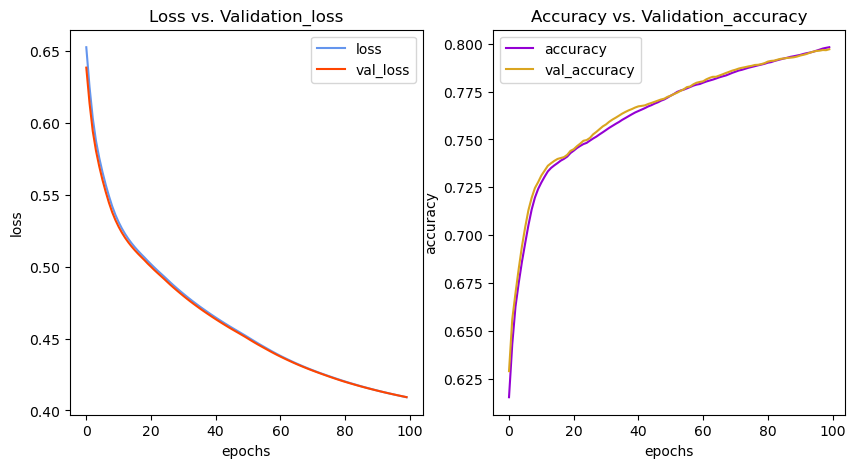

7346/7346 ━━━━━━━━━━━━━━━━━━━━ 5s 690us/step - accuracy: 0.8464 - loss: 0.3379
Training loss: 0.3390556871891022
Training accuracy: 0.8460572957992554


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/step - accuracy: 0.8466 - loss: 0.3359
Testing loss: 0.33989378809928894
Testing accuracy: 0.8450175523757935


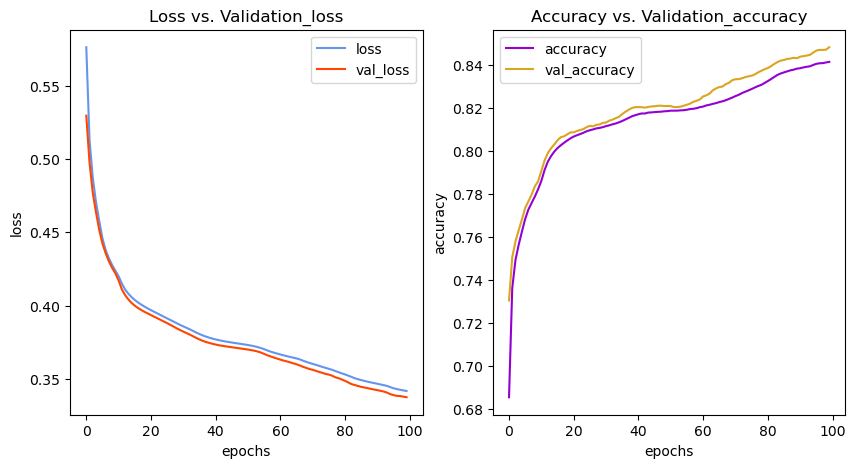

7346/7346 ━━━━━━━━━━━━━━━━━━━━ 5s 675us/step - accuracy: 0.8471 - loss: 0.3304
Training loss: 0.33245575428009033
Training accuracy: 0.8467848300933838


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step - accuracy: 0.8476 - loss: 0.3301
Testing loss: 0.33521392941474915
Testing accuracy: 0.8445212244987488


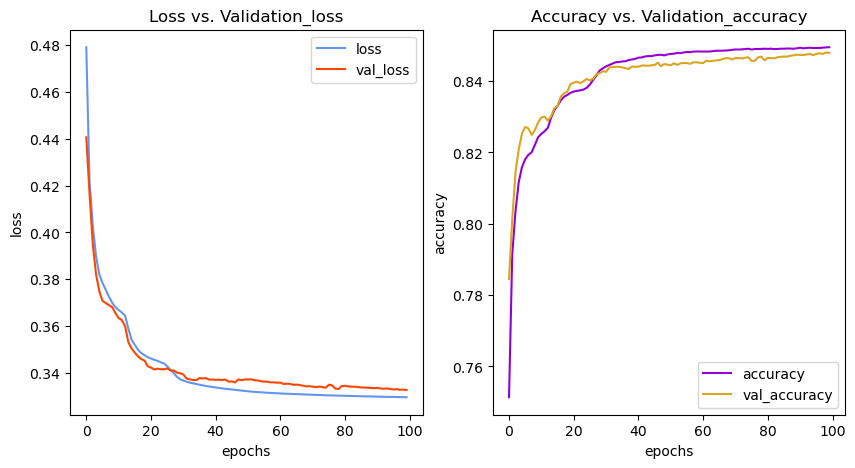

In [42]:
learning_rates = [0.0001, 0.001, 0.01]

for learning_rate in learning_rates:
    train_FNN(learning_rate, 100, 32)

7346/7346 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.7856 - loss: 0.4274
Training loss: 0.4291411340236664
Training accuracy: 0.783996045589447


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7864 - loss: 0.4260
Testing loss: 0.4304172992706299
Testing accuracy: 0.7834693193435669


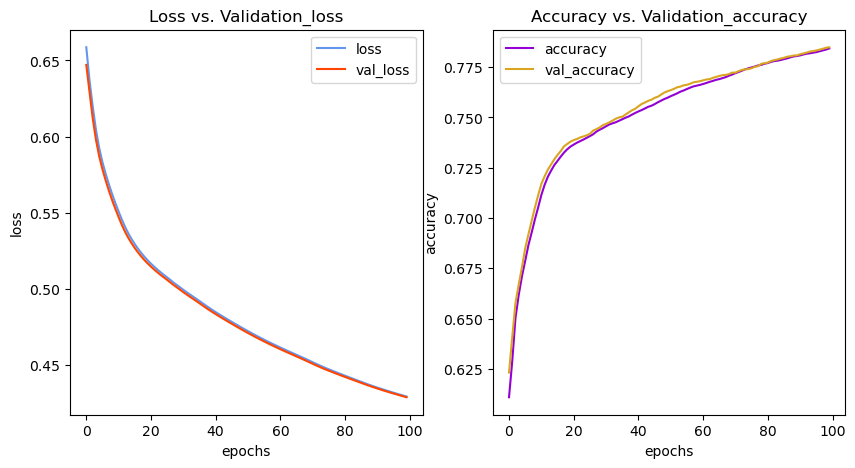

7346/7346 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.8276 - loss: 0.3701
Training loss: 0.37127885222435
Training accuracy: 0.827277660369873


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8279 - loss: 0.3668
Testing loss: 0.36940041184425354
Testing accuracy: 0.8259177803993225


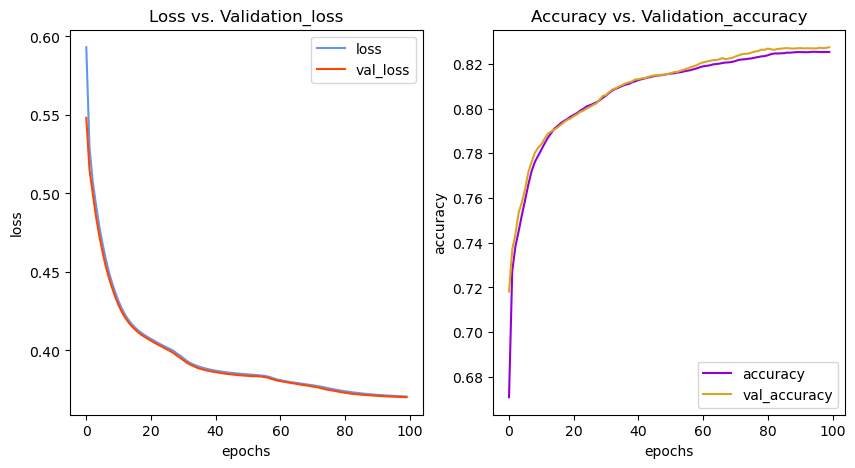

7346/7346 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8315 - loss: 0.3462
Training loss: 0.3463001549243927
Training accuracy: 0.8315705060958862


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8296 - loss: 0.3463
Testing loss: 0.3501296937465668
Testing accuracy: 0.8273869752883911


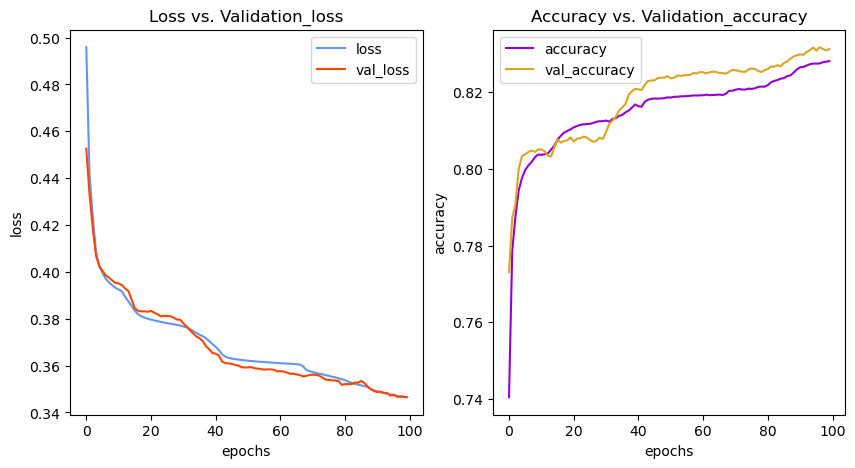

In [43]:
learning_rates = [0.0001, 0.001, 0.01]

for learning_rate in learning_rates:
    train_FNN(learning_rate, 100, 64)

7346/7346 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.7709 - loss: 0.4524
Training loss: 0.45384681224823
Training accuracy: 0.7694199085235596


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7712 - loss: 0.4510
Testing loss: 0.45513325929641724
Testing accuracy: 0.7681418657302856


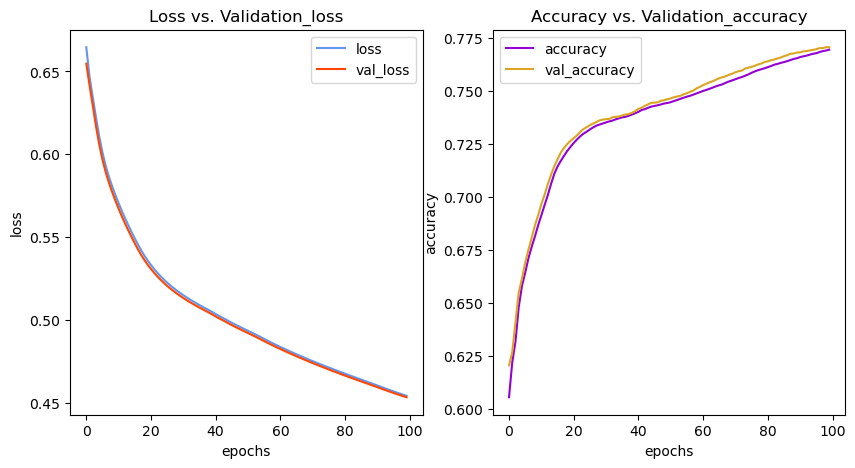

7346/7346 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.8223 - loss: 0.3800
Training loss: 0.3807222247123718
Training accuracy: 0.8215042352676392


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8221 - loss: 0.3792
Testing loss: 0.38127151131629944
Testing accuracy: 0.8219072222709656


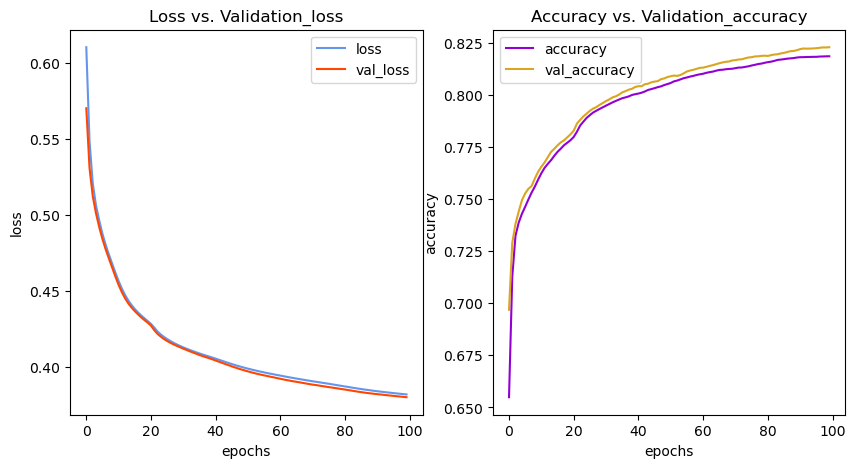

7346/7346 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8445 - loss: 0.3292
Training loss: 0.32842788100242615
Training accuracy: 0.8448617458343506


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8468 - loss: 0.3276
Testing loss: 0.3305090665817261
Testing accuracy: 0.8440049886703491


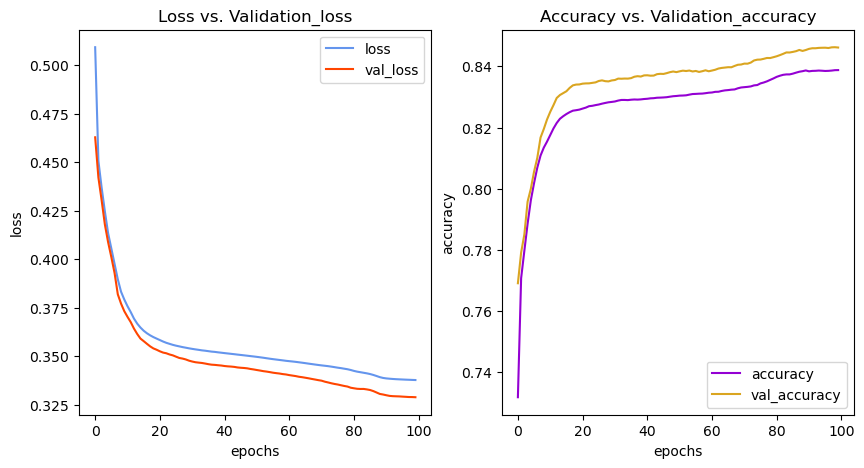

In [44]:
learning_rates = [0.0001, 0.001, 0.01]

for learning_rate in learning_rates:
    train_FNN(learning_rate, 100, 128)

7346/7346 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.7564 - loss: 0.4743
Training loss: 0.4753904938697815
Training accuracy: 0.7555245161056519


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7572 - loss: 0.4728
Testing loss: 0.4764089286327362
Testing accuracy: 0.7545615434646606


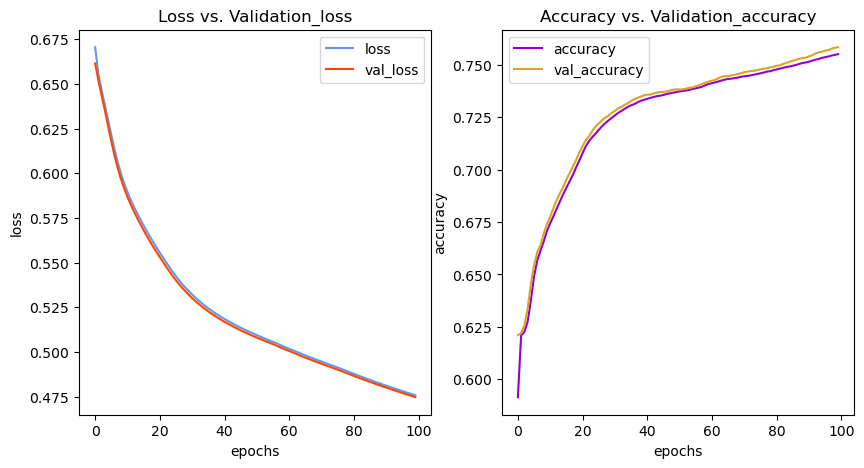

7346/7346 ━━━━━━━━━━━━━━━━━━━━ 5s 668us/step - accuracy: 0.8159 - loss: 0.3892
Training loss: 0.38997170329093933
Training accuracy: 0.8150755763053894


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step - accuracy: 0.8167 - loss: 0.3885
Testing loss: 0.39048197865486145
Testing accuracy: 0.8159112334251404


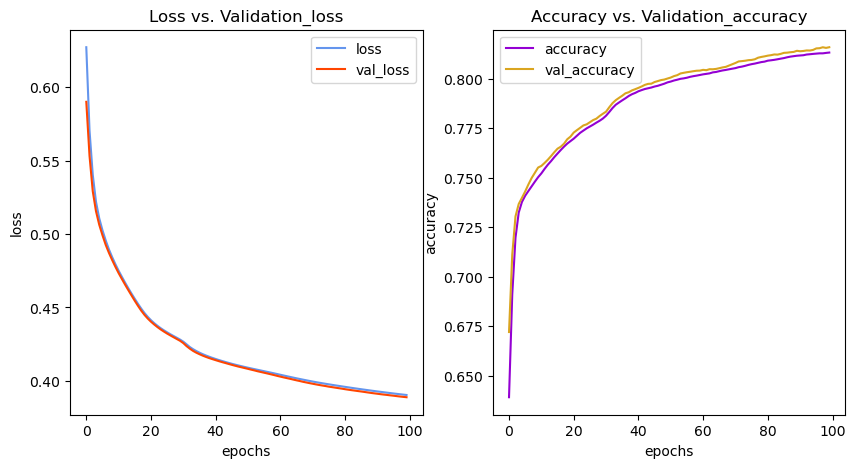

7346/7346 ━━━━━━━━━━━━━━━━━━━━ 5s 732us/step - accuracy: 0.8429 - loss: 0.3375
Training loss: 0.3380589485168457
Training accuracy: 0.842960000038147


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/step - accuracy: 0.8446 - loss: 0.3336
Testing loss: 0.3383905589580536
Testing accuracy: 0.8425953388214111


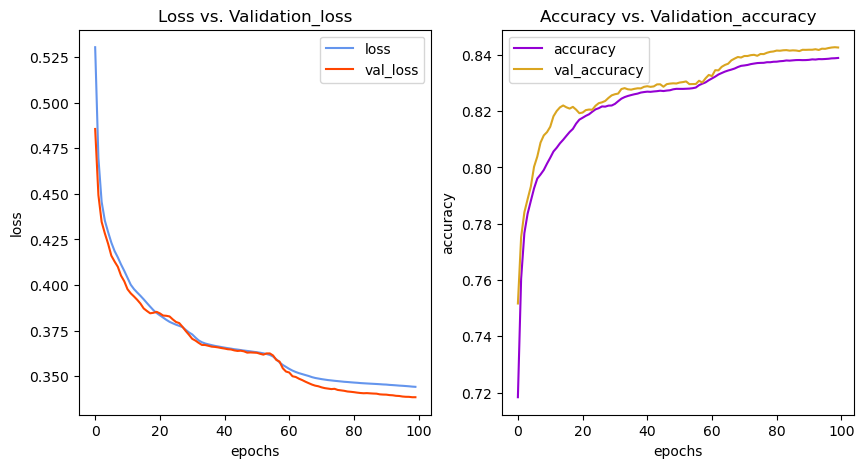

In [45]:
learning_rates = [0.0001, 0.001, 0.01]

for learning_rate in learning_rates:
    train_FNN(learning_rate, 100, 256)

# Evaluate first FNN model performance

All of the batch sizes `batch_size=32`, `64`, `128`, and `256` performed best with `learning_rate=0.01`, slightly worse by 1 to 3% for the middle `learning_rate=0.001`, and nearly 10% worse with the lowest `learning_rate=0.0001`. The pattern shows that the higher the batch size, the progressively worse the model performs within each learning rate. However, the higher the learning rate, the better the accuracy and loss.

This model architecture with one hidden layer of 16 neurons produced basically the same loss and accuracy for the train and test set. This means it's not really overfitting with a 100 epochs, but it could definitely do better with some model adjustments since the losses for both sets are higher than ideal.

**BEST RESULTS (FNN combination: `learning_rate=0.01`, `epochs=100`, and `batch_size=32`)**:

The best results returned a training loss and accuracy of 33.25% and 84.64% respectively, and a testing loss and accuracy of 33.52% and 84.45% respectively.

**NOTE**: The `learning_rate` and `batch_size` parameters are crucial in increasing accuracy. Without it, the model trained only on parameter `epochs=100` returned an accuracy of approximate 81% at best. These two additional parameters boosted model accuracy by about 3.5%, a significant amount.


# Change model architecture

### Try `learning_rate=0.001`, `epochs=85`, and `batch_size=32` with two additional hidden layers.

Since there are additional hidden layers, let's keep a lower `learning_rate=0.001` as opposed to the best performing `learning_rate=0.01`. The above model also seem to fluctuate with the loss and accuracy a bit, so testing for `epochs=85` is better.

7346/7346 ━━━━━━━━━━━━━━━━━━━━ 6s 764us/step - accuracy: 0.9875 - loss: 0.0343
Training loss: 0.03446969389915466
Training accuracy: 0.98732990026474


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step - accuracy: 0.9845 - loss: 0.0411
Testing loss: 0.04161522909998894
Testing accuracy: 0.984672486782074


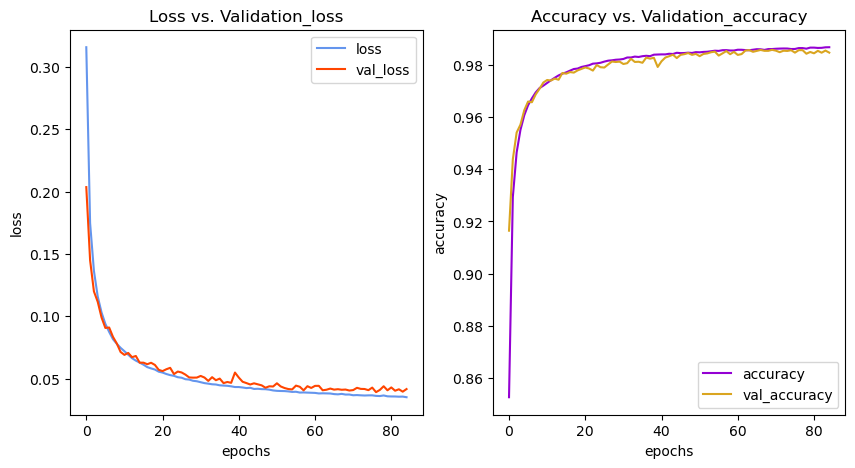

In [46]:
# random seed for reproducibility
seed_value = 100
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

# build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (C,)), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
    
# select Adam optimizer and learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
# compile model
model.compile(optimizer = optimizer, 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
    
# fit model
model_fit = model.fit(X_train, y_train, 
                      validation_data = (X_validation, y_validation), 
                      epochs = 85, batch_size=32, verbose=False)

# evaluate model train accuracy
train_loss, train_acc = model.evaluate(X_train, y_train)
print(f'Training loss: {train_loss}')
print(f'Training accuracy: {train_acc}')
    
# evaluate model test accuracy
print('\n')
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Testing loss: {test_loss}')
print(f'Testing accuracy: {test_acc}')
    
# visualize loss and accuracy
plt.subplots(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(model_fit.history['loss'], 
         label='loss', 
         color='cornflowerblue')
plt.plot(model_fit.history['val_loss'], 
         label='val_loss', 
         color='orangered')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss vs. Validation_loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(model_fit.history['accuracy'], 
         label='accuracy', 
         color='darkviolet')
plt.plot(model_fit.history['val_accuracy'], 
         label='val_accuracy', 
         color='goldenrod')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy vs. Validation_accuracy')
plt.legend()
plt.show()

# Print model architecture

In [49]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                     │ (None, 128)                 │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,397 (122.65 KB)

 Trainable params: 10,465 (40.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,932 (81.77 KB)

# Evaluate FNN performance on test set

The results returned a training loss and accuracy of 3.45% and 98.73% respectively, and a testing loss and accuracy of 4.16% and 98.47% respectively.

There is a major boost in model accuracy, so adding more hidden layers is clearly beneficial to the model. The loss for the train and test set both decreased from 30-something percent to 3-4 percent, which is a significant decrease. Similarly, the accuracies for both also increased by nearly 15%. 

In conclusion, the best hyperparameters appear to be `learning_rate=0.001`, `epochs=85`, and `batch_size=32`. While the best model architecture comprises of 8 input features: `gill-attachment`, `stem-height`, `cap-diameter`, `cap-shape`, `stem-width`, `has-ring`, `season`, and `cap-color`, three hidden layers of 128, 64, and 16 neurons each with `activation=relu`, and an output layer with `activation=sigmoid` for binary classification.

# Confusion matrix

1574/1574 ━━━━━━━━━━━━━━━━━━━━ 1s 668us/step


Text(20.72222222222222, 0.5, 'true')

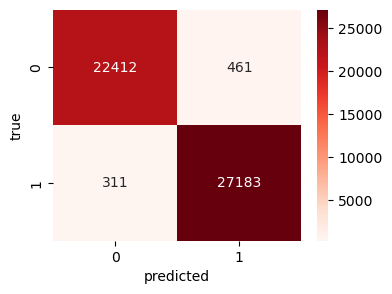

In [50]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test).flatten()

# poison=1 if probability of y_pred > 0.5, else edible=0
y_pred = np.where(y_pred > 0.5, 1, 0)

plt.figure(figsize=(4,3))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.xlabel('predicted')
plt.ylabel('true')

# Precision, recall, f1-score, etc.

In [48]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     22873
           1       0.98      0.99      0.99     27494

    accuracy                           0.98     50367
   macro avg       0.98      0.98      0.98     50367
weighted avg       0.98      0.98      0.98     50367

